In [1]:
#load packages
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import cv2

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


import glob
import os

### Evaluation

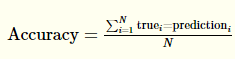

In [2]:
# general_path = os.getcwd()
# general_path

In [39]:
#path to data

TRAIN_LABELS_PATH = './data/street-view-getting-started-with-julia/trainLabels.csv'
TRAIN_IMG_PATH = './data/street-view-getting-started-with-julia/trainResized/'
TEST_IMG_PATH = './data/street-view-getting-started-with-julia/testResized/'

In [40]:
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH,  index_col='ID')
train_labels_df.reset_index(inplace=True)
train_labels_df

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R
...,...,...
6278,6279,N
6279,6280,I
6280,6281,P
6281,6282,N


#### Delete invalid images

In [41]:
train_labels_df.drop([283, 1232, 2289, 3135, 3558], inplace=True)
train_labels_df.reset_index(drop=True, inplace=True)
train_labels_df

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R
...,...,...
6273,6279,N
6274,6280,I
6275,6281,P
6276,6282,N


### EDA

In [42]:
#Nan values
train_labels_df.isna().sum()

ID       0
Class    0
dtype: int64

In [43]:
#data type
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6278 entries, 0 to 6277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      6278 non-null   int64 
 1   Class   6278 non-null   object
dtypes: int64(1), object(1)
memory usage: 98.2+ KB


In [44]:
#Quantity of elements by class
count_values_df = pd.DataFrame(train_labels_df['Class'].value_counts())
count_values_df.reset_index(inplace=True)
count_values_df.rename({'index':'Class', 'Class': 'Quantity'}, axis=1, inplace=True)
count_values_df

,Class,Quantity
0,A,459
1,E,357
2,R,309
3,O,290
4,N,279
...,...,...
57,x,23
58,Q,21
59,8,21
60,z,20


In [45]:
#indexes by label
tst = train_labels_df.copy()
tst['ID'] = tst['ID'].apply(str)
id_by_class_df = tst.groupby('Class')['ID'].apply(list).reset_index(name='IDs')
id_by_class_df

,Class,IDs
0,0,"[42, 55, 200, 224, 235, 313, 402, 475, 498, 62..."
1,1,"[48, 57, 98, 381, 976, 1138, 1168, 1202, 1229,..."
2,2,"[81, 199, 302, 342, 356, 470, 533, 660, 668, 7..."
3,3,"[149, 426, 677, 873, 952, 1013, 1290, 1741, 17..."
4,4,"[150, 194, 512, 537, 990, 1048, 1056, 1219, 13..."
...,...,...
57,v,"[238, 261, 760, 1567, 1571, 1637, 1881, 1962, ..."
58,w,"[25, 74, 361, 787, 983, 1263, 1275, 1868, 2065..."
59,x,"[190, 522, 1137, 1182, 1613, 1866, 1956, 2247,..."
60,y,"[282, 509, 678, 940, 1087, 1105, 1185, 1308, 1..."


In [46]:
rand_arr = np.asarray(id_by_class_df['IDs'][id_by_class_df['Class'] == 'w'].item())[np.random.choice(9, size=30, replace=True)]
rand_arr

array(['1275', '74', '25', '983', '983', '361', '983', '1263', '1868',
       '2065', '1263', '1275', '1868', '787', '787', '1275', '2065',
       '787', '74', '787', '74', '25', '1263', '361', '25', '25', '787',
       '25', '25', '1275'], dtype='<U4')

(array([4., 3., 6., 3., 0., 2., 3., 2., 2., 5.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

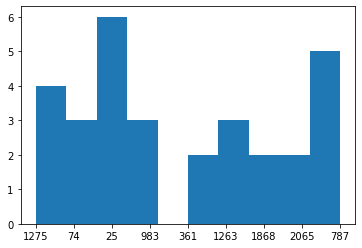

In [47]:
plt.hist(rand_arr)

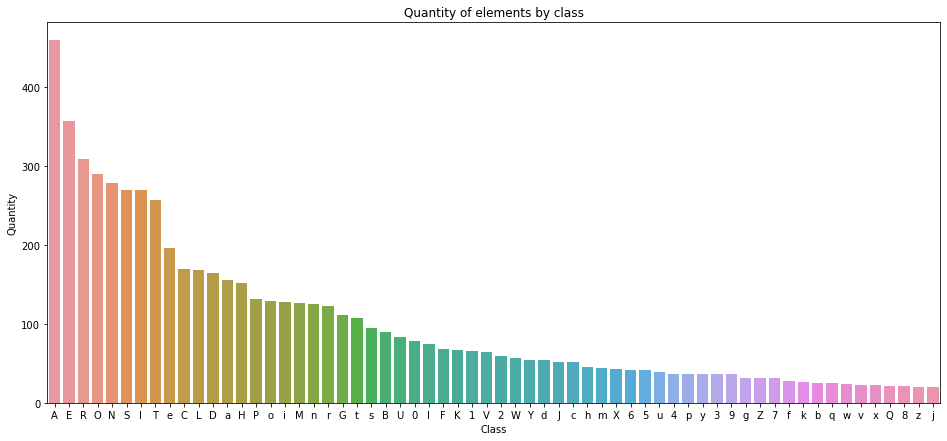

In [48]:
plt.figure(figsize=(16,7))
sns.barplot(x = 'Class', y = 'Quantity',data = count_values_df).set_title('Quantity of elements by class');

In [49]:
#search missed images

def get_imnames():
    txtfiles = []
    for file in glob.glob(TRAIN_IMG_PATH + "*.Bmp"):
        file = file.split('\\')[-1][:-4] #get only filename
        txtfiles.append(file)
        
    return txtfiles

In [50]:
txtfiles = get_imnames()
print('All images unique') if len(txtfiles) == len(set(txtfiles)) else None
print('All images correspond to labels') if set(np.asarray(list(map(str, train_labels_df['ID'])))) == set(txtfiles) else None

All images unique
All images correspond to labels


#### Inspect Images

In [51]:
def display_image(id_):
    sample_img = TRAIN_IMG_PATH + str(id_) + '.Bmp'
    img= imread(sample_img)
    imshow(img);
    print('Letter:', train_labels_df.set_index('ID').loc[id_].values[0])

Letter: u


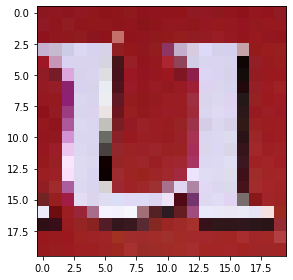

In [52]:
display_image(14)

### Augmentation

In [53]:
(train_labels_df, count_values_df, id_by_class_df) != None

True

In [54]:
def get_image(id_):
    sample_img = TRAIN_IMG_PATH + str(id_) + '.Bmp'
    img= imread(sample_img, as_gray=False)
    letter = train_labels_df.set_index('ID').loc[id_].values[0]
    
    return img, letter


def hist_equal(img):
    img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    
    return hist_equalization_result


def augmentation(img_):
    grayscale_img = cv2.cvtColor(cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
    hist_equal_img = hist_equal(img_)
    median_blure_img = cv2.medianBlur(img_,3)
    gauss_blur_img = cv2.GaussianBlur(img_,(3,3),3)
    
    return grayscale_img, hist_equal_img, median_blure_img, gauss_blur_img


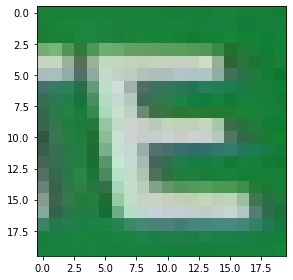

'E'

In [55]:
img, letter = get_image(1232)
plt.show(imshow(img))
letter

In [56]:
# def hist_equal(img):
#     img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
#     hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
#     return hist_equalization_result


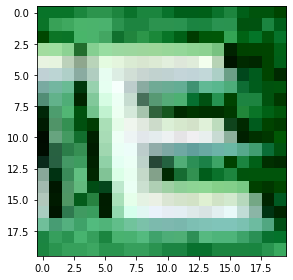

In [57]:
imshow(hist_equal(img));

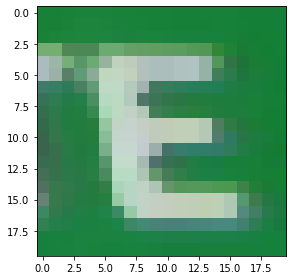

In [58]:
imshow(cv2.medianBlur(img,3));

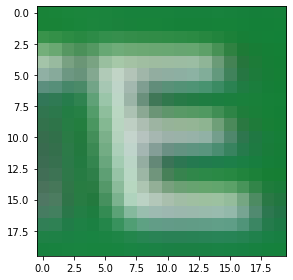

In [59]:
imshow(cv2.GaussianBlur(img,(3,3),3))

In [60]:
# def augmentation(img_):
#     grayscale_img = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
#     hist_equal_img = hist_equal(img_)
#     median_blure_img = cv2.medianBlur(img_,3)
#     gauss_blur_img = cv2.GaussianBlur(img_,(3,3),3)
    
#     return grayscale_img, hist_equal_img, median_blure_img, gauss_blur_img


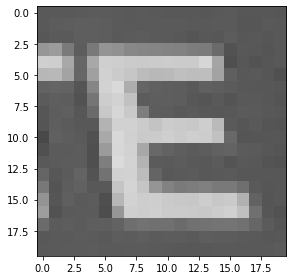

In [61]:
grayscale_img, hist_equal_img, median_blure_img, gauss_blur_img = augmentation(img)
imshow(grayscale_img)

In [62]:
# id_by_class_df

In [63]:
# count_values_df

In [64]:
# train_labels_df

In [65]:
# for i in range(6284, 18748):
#     os.remove(TRAIN_IMG_PATH + str(i) + '.Bmp')
#     print(i) if i%1000 == 0 else None

#### Generate images

In [66]:
img_id_counter = 6284  #new id
new_img_df = pd.DataFrame(columns=['ID','Class'])
for idx, row in count_values_df.iterrows():
    
    if row['Quantity'] < 300:
        diff = 300 - row['Quantity']
        print(row['Class'])
        print(img_id_counter)
        img_id_arr = np.asarray(id_by_class_df['IDs'][id_by_class_df['Class'] == row['Class']].item()) #get images ids
        img_id_arr_chosen = img_id_arr[np.random.choice(len(img_id_arr), size=diff // 4, replace=True)]  #choose randomly ids
        
        for img_id in img_id_arr_chosen:
            try:
                img, letter = get_image(int(img_id))  #get image
            except:
                print('Unable to read image {}'.format(img_id))   
                
            try:
                aug_img_list = list(augmentation(img))   #image augmentation
            except:
                print('Unable to augment image {}'.format(img_id))
            
            for aug_img in aug_img_list:
                
                aug_im = Image.fromarray(aug_img)
                aug_im.save(TRAIN_IMG_PATH +  str(img_id_counter) + '.Bmp')  #image from array and save 
                new_img_df = new_img_df.append({'ID': img_id_counter, 'Class': letter}, ignore_index=True)
                
                img_id_counter += 1
            
  
            
#             grayscale_img, hist_equal_img, median_blure_img, gauss_blur_img = augmentation(img)   #image augmentation
            
            
#             grayscale_im = Image.fromarray(grayscale_img)
#             grayscale_im.save(TRAIN_IMG_PATH + str(img_id) + '.Bmp')  #image from array and save
            
#             new_img_df['ID'] = img_id
#             new_img_df['Class'] = letter
            
#             img_id += 1
            
            
#             hist_equal_im = Image.fromarray(hist_equal_img)
#             hist_equal_im.save(TRAIN_IMG_PATH + str(img_id) + '.Bmp')  #image from array and save
            
#             new_img_df['ID'] = img_id
#             new_img_df['Class'] = letter
            
#             img_id += 1
            
            
#             median_blure_im = Image.fromarray(median_blure_img)
#             median_blure_im.save(TRAIN_IMG_PATH + str(img_id) + '.Bmp')  #image from array and save
            
#             new_img_df['ID'] = img_id
#             new_img_df['Class'] = letter
            
#             img_id += 1
            
            
#             gauss_blur_im = Image.fromarray(gauss_blur_img)
#             gauss_blur_im.save(TRAIN_IMG_PATH + str(img_id) + '.Bmp')  #image from array and save
            
#             new_img_df['ID'] = img_id
#             new_img_df['Class'] = letter
            
#             img_id += 1
     

O
6284
N
6292
S
6312
I
6340
T
6368
e
6408
C
6512
L
6640
D
6772
a
6904
H
7048
P
7196
o
7364
i
7532
M
7704
n
7876
r
8048
G
8224
t
8412
s
8604
B
8808
U
9016
0
9232
l
9452
F
9676
K
9908
1
10140
V
10372
2
10608
W
10848
Y
11088
d
11332
J
11576
c
11824
h
12072
m
12324
X
12580
6
12836
5
13092
u
13348
4
13608
p
13868
y
14128
3
14388
9
14652
g
14916
Z
15184
7
15452
f
15720
k
15992
b
16264
q
16536
w
16808
v
17084
x
17360
Q
17636
8
17912
z
18188
j
18468


In [67]:
# new_img_df

In [68]:
# train_labels_df

In [69]:
#Concat dataframes
train_df_conc = train_labels_df.append(new_img_df, ignore_index=True)
train_df_conc.reset_index(drop=True, inplace=True)
train_df_conc

,ID,Class
0,1,n
1,2,8
2,3,T
3,4,I
4,5,R
...,...,...
18737,18743,j
18738,18744,j
18739,18745,j
18740,18746,j


In [70]:
#Shuffle rows
train_df = shuffle(train_df_conc)
train_df.reset_index(inplace=True, drop=True)
train_df['ID'] = train_df['ID'].apply('int32')
train_df

,ID,Class
0,5944,H
1,11109,Y
2,11177,Y
3,1380,I
4,9773,F
...,...,...
18737,10112,K
18738,4076,S
18739,2999,S
18740,5404,h


#### Check if correct

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18742 entries, 0 to 18741
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      18742 non-null  int32 
 1   Class   18742 non-null  object
dtypes: int32(1), object(1)
memory usage: 219.8+ KB


In [72]:
txtfiles2 = get_imnames()
print('All images unique') if len(txtfiles2) == len(set(txtfiles2)) else None
print('All images correspond to labels') if set(np.asarray(list(map(str, train_df['ID'])))) == set(txtfiles2) else None

All images unique
All images correspond to labels


In [73]:
#Quantity of elements by class
count_values_df2 = pd.DataFrame(train_df['Class'].value_counts())
count_values_df2.reset_index(inplace=True)
count_values_df2.rename({'index':'Class', 'Class': 'Quantity'}, axis=1, inplace=True)
count_values_df2

,Class,Quantity
0,A,459
1,E,357
2,R,309
3,c,300
4,J,300
...,...,...
57,W,297
58,b,297
59,h,297
60,q,297


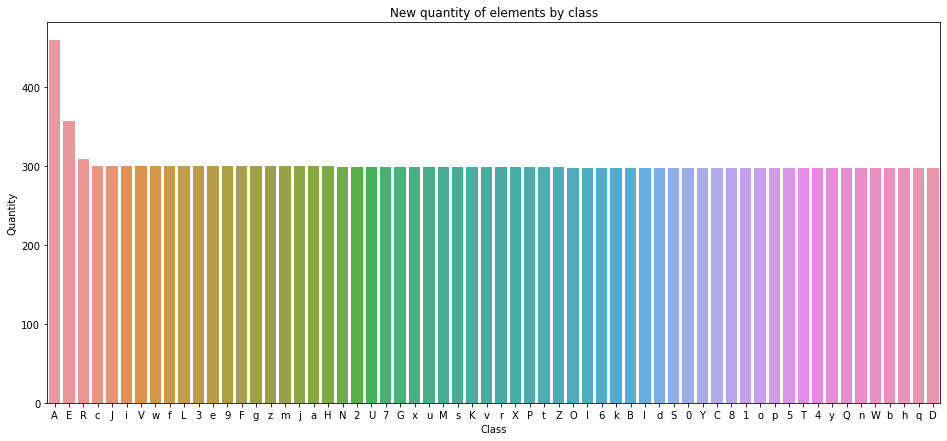

In [74]:
plt.figure(figsize=(16,7))
sns.barplot(x = 'Class', y = 'Quantity',data = count_values_df2).set_title('New quantity of elements by class');

#### Save new train labels

In [76]:
#save new labels

# train_df.to_csv('./data/street-view-getting-started-with-julia/TrainLabelsExtended.csv' , index=False)

### Encode labels

#### Label Encoding

In [68]:
train_labels_df_enc = train_labels_df.copy()

In [70]:
label_enc = LabelEncoder()
train_labels_df_enc['Class'] = label_enc.fit_transform(train_labels_df_enc['Class'])
train_labels_df_enc

,Class
ID,
1,49
2,8
3,29
4,18
5,27
...,...
6279,23
6280,18
6281,25


In [72]:
len(train_labels_df_enc['Class'].unique())

62

In [73]:
replaced_labels = dict(enumerate(label_enc.classes_))
# replaced_labels